`ypp` (_pronounced Yippee!) helps manager your interactive state. `ypp.Output` objects are evented `traitlets` or `ipywidgets`
that update as the interative state of an `IPython.InteractiveShell` is changed.  `ypp.Handler` objects are evented to change
within special `globals` and `locals` namepsaces.

In [1]:
    import contextlib , sys, IPython, traitlets, contextlib, functools, itertools

    try: import ipywidgets
    except: ipywidgets = None
        
    if __name__ == '__main__': 
        get_ipython = IPython.get_ipython
        %reload_ext ypp
        from ypp import *
        import ypp
        get_ipython().run_line_magic("reload_ext", "pidgin")


In [2]:
    class Output(traitlets.HasTraits):
`Output` is the base class for the `ypp` interactive `ypp.TraitletOutput` & `ypp.WidgetOutput`.
>>> Output()
<...Output...>

        value = traitlets.Any()
        description = traitlets.Unicode()

In [3]:
    class TraitletOutput(IPython.display.DisplayHandle, Output):
`TraitletOutput` is a non-`ipywidgets` interactive `Output` thats updates using the builtin
`IPython.display.DisplayHandle` system.
        
        def _ipython_display_(TraitletOutput, before=None, after=None):
`TraitletOutput._ipython_display_` displays the `TraitletOutput.description` if it exists 
and then displays the `TraitletOutput.value`.  `TraitletOutput` manages updating existing display objects.
            
            if TraitletOutput.description:
                IPython.display.display(IPython.display.Markdown('#### ' + TraitletOutput.description))
            TraitletOutput.display(TraitletOutput.value)

    
        @traitlets.observe('value')
        def _change_value(TraitletOutput, change): 
When `TraitletOutput.value` changes `TraitletOutput._change_value` triggers the `IPython.display.DisplayHandle` to __update__.
            
            TraitletOutput.update(change['new'])

        stack = traitlets.List()        
        def __enter__(TraitletOutput):
`TraitletOutput.__enter__` changes the context of how display objects are published using `IPython.utils.capture`.
            
            object = IPython.utils.capture.capture_output()  
We use a stack just in case...

            TraitletOutput.stack.append((object, object.__enter__()))
            
        def __exit__(TraitletOutput, *e):
`TraitletOutput.__exit__` the `TraitletOutput.stack` and `TraitletOutput.update` any existing displays.

            capturer, captured = TraitletOutput.stack.pop()
            capturer.__exit__(*e)
            outputs = captured.outputs and captured.outputs[0].data or {'text/plain': captured.stdout}
            TraitletOutput.update(outputs, raw=True)
        
        def __init__(TraitletOutput, *args, **kwargs):
            IPython.display.DisplayHandle.__init__(TraitletOutput)
            Output.__init__(TraitletOutput, *args, **kwargs)

In [4]:
    class ListOutput(TraitletOutput):
        def _ipython_display_(ListOutput, before=None, after=None):
            if ListOutput.description:
                IPython.display.display(IPython.display.Markdown('#### ' + ListOutput.description))
            IPython.display.display(*ListOutput.value)


In [5]:
    class Handler(traitlets.HasTraits):
`Handler` is a `traitlets` `object` that manager state between itself and the `Handler.parent`.
>>> handler = Handler(foo=2)
>>> handler
<...Handler...>

        parent = traitlets.Instance(IPython.InteractiveShell, help=
`Handler.parent` is a shell who's namespace is evented with the `Handler`.
>>> handler.parent
<...Shell...>
            
                                   )
        children = traitlets.Tuple(help=
`Handler.children` holds the widgets for the `Handler`
                                  
                                  )
        display = traitlets.Dict(help=
`Handler.display` is a keyed version of the `Handler.children`.
>>> assert handler.children == tuple(handler.display.values())
                                 
                                )
        wait = traitlets.Bool(False)
        display_cls = traitlets.Type(TraitletOutput, help=
>>> assert issubclass(handler.display_cls, Output)
                                    
                                    )
        callable = traitlets.Any()
        globals = traitlets.Dict()
        locals = traitlets.Dict()
        container = traitlets.Any()
        
        def default_container(App):
            return ListOutput(value=list(App.children))
        
        def __init__(App, *globals, wait=False, parent=None, **locals):
            func = locals.pop('callable', None)
            parent=parent or IPython.get_ipython()
            globals = {str: parent.user_ns.get(str, None) for str in map(str.strip, itertools.chain(*map(str.split, globals))) if str not in locals}
            locals.update({k: locals.get(k, None) or value  for k, value in getattr(App, '__annotations__', {}).items()})
            super().__init__(parent=parent, wait=wait, callable=func, locals=locals, globals=globals)
            App.wait or App.parent.events.register('post_execute', App.user_ns_handler)

            if not App.callable and callable(App): App.callable = lambda _: App()
            
            for alias, dict in zip('globals locals'.split(), (App.globals, App.locals)):
                for name, object in dict.items():
                    App.display[name] = widget = App.widget_from_abbrev(name, object)
                    App.children += widget,
                    if 'value' in widget.traits():
                        App.add_traits(**{name: type(widget.traits()['value'])(widget.value)})
                        if App.wait: App.wait_handler
                        else:  traitlets.link((widget, 'value'), (App, name))
                    if name in App.globals: App.observe(App.globals_handler, name)    
                            
            if App.callable: 
                App.children += App.display_cls(description='result', value=App.callable(App)),
                App.observe(App.call)
                
            App.container = App.default_container()

        def user_ns_handler(App, *args):
            with pandas_ambiguity(): 
                [str in App.parent.user_ns and setattr(App, str, App.parent.user_ns[str]) for str in App.globals]
        
        def globals_handler(App, change):
            if change['type'] == 'change':  
                setattr(App, change['name'], change['new'])
                App.parent.user_ns[change['name']] = change['new']

        def call(App, change):
            with pandas_ambiguity(), App.children[-1]:
                value = App.callable(App); 
                IPython.display.display(value)
        
        def wait_handler(App, change): ...
        def widget_from_abbrev(App, name, object): return App.display_cls(description=name, value=object)
        def __enter__(App): return App
        def __exit__(App, *e): 
            for children in App.children[0]: [hasattr(child, 'value') and child.unobserve('value') for child in children]
            App.unobserve(None), App.wait or App.parent.events.unregister('post_execute', App.user_ns_handler)
        
        def _ipython_display_(App): IPython.display.display(App.container)

In [6]:
    @contextlib.contextmanager
    def pandas_ambiguity(nz=None):
        pandas = sys.modules.get('pandas', None)
        if pandas:
            pandas.Series.__bool__ = pandas.DataFrame.__bool__ = lambda df: True
            yield
            try: del pandas.DataFrame.__bool__, pandas.Series.__bool__
            except: ...
        else: yield

In [7]:
    if ipywidgets:
        class WidgetOutput(ipywidgets.Accordion, Output):
            output = traitlets.Instance(ipywidgets.Output)

            def __init__(WidgetOutput, *args, **kwargs):
                kwargs['output'] = kwargs.get('output', ipywidgets.Output())
                super().__init__(*args, **kwargs)
                WidgetOutput.children += WidgetOutput.output,
                WidgetOutput._titles = {0: WidgetOutput.description}
                WidgetOutput.observe(WidgetOutput.update, 'value')
                WidgetOutput.update({'new': WidgetOutput.value})

            @traitlets.observe('selected_index')
            def _change_index(WidgetOutput, change):
                if WidgetOutput.selected_index is None: WidgetOutput._titles = {0: F'''{WidgetOutput.description} of type {type(WidgetOutput.value)}'''}
                else: WidgetOutput._titles = {0: WidgetOutput.description}

            def __enter__(WidgetOutput): 
                WidgetOutput.output.clear_output(True)
                WidgetOutput.output.__enter__()
            def __exit__(WidgetOutput, *e): WidgetOutput.output.__exit__(*e)
            def update(WidgetOutput, change):
                with WidgetOutput: IPython.display.display(change['new'])
                    
                if not WidgetOutput.selected_index: WidgetOutput._change_index({'new': None})

        w = WidgetOutput(value=range, description='Test')

In [8]:
    if ipywidgets:
        class App(Handler):
            children = traitlets.Tuple()
            display_cls = traitlets.Type(WidgetOutput)
            
            def default_container(App):
                children = []
                for alias, dict in zip('globals locals'.split(), (App.globals, App.locals)):
                    if dict:
                        children.append(ipywidgets.Accordion(children=[ipywidgets.VBox(layout={"display": "flex"})], _titles={0:alias}))
                        for name, object in dict.items(): children[-1].children[0].children += patch_child(App.display[name]),
                App.container.children = tuple(children)            
                if App.callable: App.container.children += App.children[-1],
                return ipywidgets.VBox(children=tuple(children))

            _ = traitlets.default('container')(lambda x: ipywidgets.VBox())
            def widget_from_abbrev(App, name, object, *, widget = None):
                annotation = {**App.parent.user_ns.get('__annotations__', {}), **getattr(App, '__annotations__', {})}.get(name, object)
                if 'pandas' in sys.modules and isinstance(object, sys.modules['pandas'].DataFrame): ...
                elif isinstance(annotation, list): widget = ipywidgets.SelectMultiple(options=tuple(annotation), value=object)
                elif isinstance(annotation, ipywidgets.Widget): widget = annotation
                else: 
                    widget = ipywidgets.interactive.widget_from_abbrev(annotation, App.locals.get(name, App.parent.user_ns.get(name, object)))
                widget = widget or WidgetOutput(description=name, value=object)
                widget.description = name
                return widget

In [9]:
    try:
        import ipywxyz
        class WXYZ(App):
            container = traitlets.Instance(ipywxyz.DockBox, allow_none=True)            
            def default_container(App):
                return ipywxyz.DockBox(children=tuple(map(patch_child, App.children)), layout={'height': '20vh'})
    except: ...

In [10]:
    def patch_child(child):
        if isinstance(child, TraitletOutput):
            output = ipywidgets.Output()
            with output: IPython.display.display(child)
            return output 
        return child

In [11]:
    if ipywidgets:
        class ypp(ipywidgets.VBox):
The `ypp` application combines `Handler`, `App`, and `WXYZ` into a single widget that modifed interactively.  This
turns out to be a great way to generate new dockpanels.

>>> app=App(foo=2)
>>> y = ypp.ypp(app=app, value='normal')
        
            app = traitlets.Instance(Handler)
            mode = traitlets.Any()
            value = traitlets.Any('embedded')

            @traitlets.default('mode')
            def default_mode(ypp): return ipywidgets.SelectionSlider(options=['normal', 'embedded', 'dockable'])

            def __init__(ypp, *args, **kwargs):
                if 'app' not in kwargs:
                    super().__init__(app=App(*args, **kwargs))
                else:
                    super().__init__(*args, **kwargs)
                    
                ypp.children = ypp.mode, ipywidgets.Output()            
                ypp.switch_container({'new': ypp.mode.value})
                traitlets.link((ypp, 'value'), (ypp.mode, 'value'))
                ypp.observe(ypp.switch_container, 'value')

            def switch_container(ypp, change):
                default_container = {'normal': Handler, 'embedded': App, 'dockable': WXYZ}[change['new']]      
                ypp.children[-1].clear_output(True)
                with ypp.children[-1]: IPython.display.display(default_container.default_container(ypp.app))

In [12]:
    @IPython.core.magic.magics_class
    class Magic(IPython.core.magic.Magics):
>>> %ypp foo
ypp...
>>> %%ypp
...        print(foo)
WidgetOutput(...Output...)

        @IPython.core.magic.line_magic('ypp')
        def line(self, line): return ypp(line)

        @IPython.core.magic.cell_magic('ypp')
        def cell(self, line, cell):
            app = ypp(line, output=None)
            self.update(cell, app.app, {})
            app.app.observe(functools.partial(self.update, cell, app.app), line.split())
            return app
        
        def update(self, cell, app, change): 
            app.parent.events.trigger('post_execute')
            with app.display['output']: IPython.get_ipython().run_cell(cell)

**********************************************************************
Line 5, in _test_
Failed example:
    %%ypp
           print(foo)
Expected:
    WidgetOutput(...Output...)
Got:
    ypp(children=(SelectionSlider(index=1, options=('normal', 'embedded', 'dockable'), value='embedded'), Output()))


In [13]:
    def load_ipython_extension(shell): shell.register_magics(Magic)
    def unload_ipython_extension(shell): ...

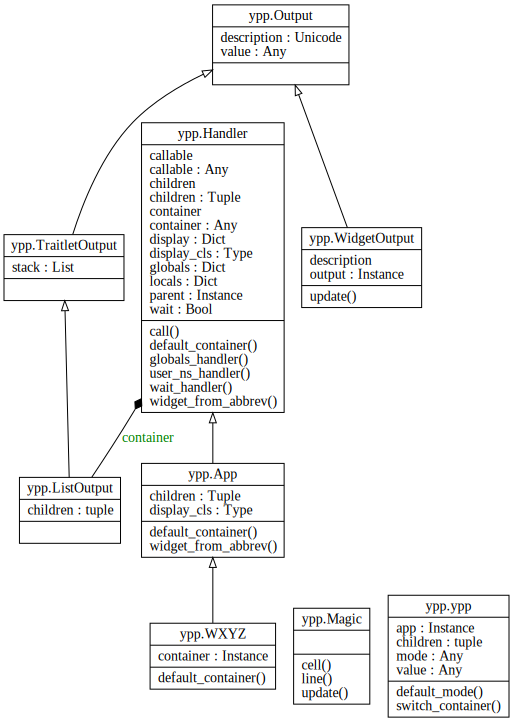

ypp.py:26: 'from ypp import *' used; unable to detect undefined names
ypp.py:26: 'ypp.*' imported but unused
ypp.py:343: redefinition of unused 'ypp' from line 27


In [19]:
    if __name__ == '__main__':
        import pidgin, nbconvert, black
        display = IPython.display.display
        with open('ypp.py', 'w') as f:
            f.write(black.format_str(nbconvert.PythonExporter(config={
                'TemplateExporter': {'exclude_input_prompt': True}
            }, preprocessors=[pidgin.publishing.TanglePreProcessor()]).from_filename('ypp.md.ipynb')[0], mode=black.FileMode()))
            if 0:
                with IPython.utils.capture.capture_output():
                    !pyreverse --show-builtin  --module-names=y -osvg -b ypp 
            display(IPython.display.SVG('classes.svg'))
            with IPython.utils.capture.capture_output():
                !isort ypp.py
        if 10:
            !pyflakes ypp.py